In [1]:
import os

In [2]:
%pwd

'd:\\GUVI Machine Learning BootCamp\\Final Project\\Customer Review Research\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'd:\\GUVI Machine Learning BootCamp\\Final Project\\Customer Review Research'

In [5]:
import pandas as pd
import numpy as np

import nltk


In [6]:
df = pd.read_csv(r"artifacts\data_transformation\customer_review_with_rating_and_polarity.csv")

In [7]:
example = df['Review-Body'][7]
print(example)

Phone is over all good but some heating problem,and selfie  selfie  is not too good.Other wise phone is good


In [8]:
example2 = df["Review-Body"][44]
print(example2)

The media could not be loaded.
                



 All good but  camera  camera not improved


# Vader Seniment

In [9]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [10]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [11]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [12]:
sia.polarity_scores(example)

{'neg': 0.133, 'neu': 0.637, 'pos': 0.231, 'compound': 0.3546}

In [18]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = str(row['Review-Body'])
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/23777 [00:00<?, ?it/s]

In [20]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [21]:
vaders.head()

,Id,neg,neu,pos,compound,Unnamed: 0,Review-Title,rating,Review-Body,Product Name,rating_num,battery,performance,display,camera
0,1,0.730,0.270,0.000,-0.4019,0,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0,0,0,0,0
1,2,0.122,0.810,0.068,-0.6019,1,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0,1,0,0,0
2,3,0.012,0.767,0.221,0.9872,2,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0,1,0,0,0
3,4,0.040,0.759,0.200,0.9789,3,One plus losing is originality!!!,3.0 out of 5 stars,The media could not be loaded.\n ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",3.0,0,0,0,1
4,5,0.054,0.865,0.081,0.2846,4,Read,1.0 out of 5 stars,I got my delivery on 23 feb when I unboxed the...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0,0,0,1,0


## RoBERTa

In [22]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Phone is over all good but some heating problem,and selfie  selfie  is not too good.Other wise phone is good


{'neg': 0.133, 'neu': 0.637, 'pos': 0.231, 'compound': 0.3546}

In [25]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.23585689, 'roberta_neu': 0.42864996, 'roberta_pos': 0.33549312}


In [26]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [28]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = str(row['Review-Body'])
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/23777 [00:00<?, ?it/s]

Broke for id 7
Broke for id 13
Broke for id 18
Broke for id 29
Broke for id 131
Broke for id 3334
Broke for id 3345
Broke for id 7501
Broke for id 10135
Broke for id 10157
Broke for id 13836
Broke for id 13864
Broke for id 13957
Broke for id 13963
Broke for id 18312
Broke for id 20725
Broke for id 20747
Broke for id 21056
Broke for id 21251


In [29]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [30]:
results_df.head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Unnamed: 0,neg,...,compound,Review-Title,rating,Review-Body,Product Name,rating_num,battery,performance,display,camera
0,1,0.730,0.270,0.000,-0.4019,0.369169,0.570488,0.060343,0,0.730,...,-0.4019,Worst phone ever,1.0 out of 5 stars,Hang problem,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",1.0,0,0,0,0
1,2,0.122,0.810,0.068,-0.6019,0.395843,0.452988,0.151169,1,0.122,...,-0.6019,Ok !!! Not up to the mark,2.0 out of 5 stars,I'm writing this review after using 3days !!!B...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",2.0,1,0,0,0
2,3,0.012,0.767,0.221,0.9872,0.001653,0.021798,0.976549,2,0.012,...,0.9872,Awesome look,5.0 out of 5 stars,Camera is so good n very fast phone back look ...,"OnePlus Nord CE 2 5G (Gray Mirror, 8GB RAM, 12...",5.0,1,0,0,0


In [31]:
vaders.to_csv("artifacts\data_transformation\customer_review_with_rating_and_roberta_polarity.csv")

## Compare Scores between models

In [32]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Unnamed: 0', 'neg', 'neu',
       'pos', 'compound', 'Review-Title', 'rating', 'Review-Body',
       'Product Name', 'rating_num', 'battery', 'performance', 'display',
       'camera'],
      dtype='object')

# Step 3. Combine and compare

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


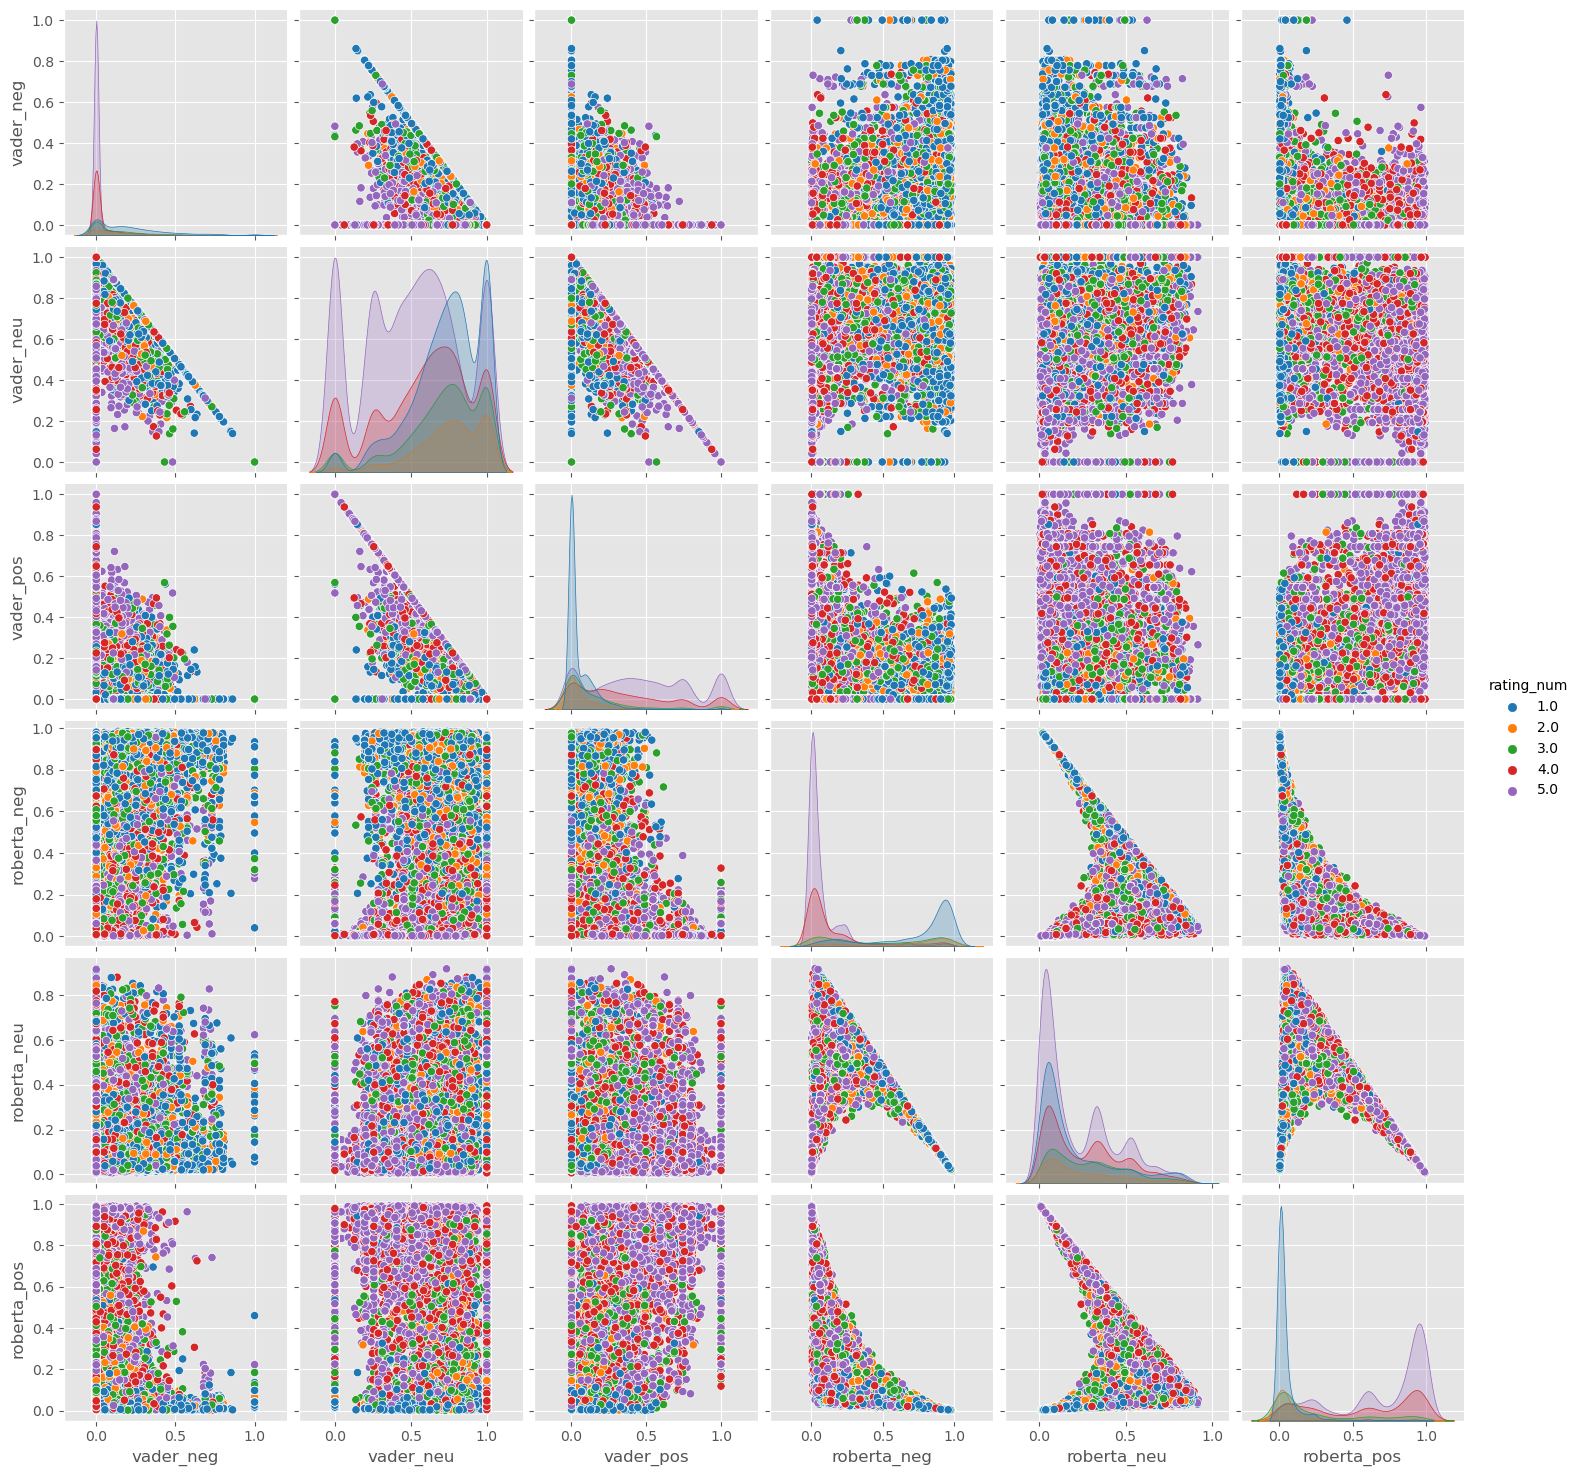

In [35]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='rating_num',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [38]:
results_df.query('rating_num == 1') \
    .sort_values('roberta_pos', ascending=False)['Review-Body'].values[0]

'Well the phone is good heart and to keep you warm .............thank you +'

In [39]:
results_df.query('rating_num == 1') \
    .sort_values('vader_pos', ascending=False)['Review-Body'].values[0]

'Good'

# negative sentiment 5-Star view

In [40]:
results_df.query('rating_num == 5') \
    .sort_values('roberta_neg', ascending=False)['Review-Body'].values[0]

"Its very bad phone its old launched and it hangs oftenDon't buy it i never recommend it"

In [41]:
results_df.query('rating_num == 5') \
    .sort_values('vader_neg', ascending=False)['Review-Body'].values[0]

'No'